In [16]:
import pandas as pd
import numpy as np

training = pd.read_csv('new train data.csv')
# pd.set_option('display.max_columns', 150)
# pd.set_option('display.max_rows', 150)

# ProductCD: product code of each transaction; there are 5 product types
training['ProductCD'].value_counts()

(40788, 112)

In [4]:
# card4: brand of card; there are 4 brands
training['card4'].value_counts()

visa                26710
mastercard          12944
discover              609
american express      525
Name: card4, dtype: int64

In [5]:
# card6: type of card; we drop the 3 unique rows of 'debit or credit' and 'charge card'
training['card6'].value_counts()
mask = training['card6'] != 'debit or credit'
training = training[mask]
mask2 = training['card6'] != 'charge card'
training = training[mask2]
training.shape

(40785, 112)

In [6]:
# create into category type
training['card6'] = training['card6'].astype('category')
training['card4'] = training['card4'].astype('category')
training['ProductCD'] = training['ProductCD'].astype('category')

# encode into numeric categories; we opt for dummy variables (One Hot Encoding)
training_dummies = pd.get_dummies(training, columns=['card4', 'card6', 'ProductCD'])

In [40]:
from sklearn import preprocessing

# initialize scaler
scaler = preprocessing.MinMaxScaler()

# drop target column
training_v1 = training_dummies.drop('TransactionID', axis=1)
training_v2 = training_v1.drop('isFraud', axis=1)
training_y = training_dummies['isFraud'].copy()
training_id = training_dummies['TransactionID'].copy()

# Fit the data with scaler (scales data)
training_v2 = training_v2.set_index('Unnamed: 0')
x = training_v2.values
x_scaled = scaler.fit_transform(x)
training_scaled = pd.DataFrame(x_scaled)
training_scaled = training_scaled.set_axis([x for x in training_v2.columns], axis=1, inplace=False)
training_scaled.insert(loc=0, column='TransactionID', value=training_id)
training_scaled['y'] = training_y
training_scaled = training_scaled.dropna()
training_scaled['TransactionID'] = training_scaled['TransactionID'].astype(int)
training_scaled.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card3,card5,C1,C2,C3,C4,...,card4_mastercard,card4_visa,card6_credit,card6_debit,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,y
0,3273604,0.443036,0.020744,0.488205,0.381679,0.919708,0.000214,0.000176,0.0,0.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2999170,0.016551,0.011435,0.443326,0.381679,0.919708,0.013456,0.007557,0.0,0.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3023872,0.053123,0.014002,0.918124,0.381679,0.919708,0.023708,0.016872,0.0,0.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3033043,0.064770,0.009580,0.663003,0.381679,0.905109,0.000214,0.000176,0.0,0.000444,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3422561,0.695863,0.025946,0.488205,0.381679,0.919708,0.000641,0.000351,0.0,0.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# initialize Random Forest model and split data into training and validation
clf = RandomForestClassifier()
y = training_scaled['y'].copy()
training_scaled = training_scaled.drop(['y'], axis=1)
x = training_scaled.drop(['TransactionID'], axis=1)
x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=42)

In [54]:
from sklearn.model_selection import cross_val_score
# fit our data to the model and cross-validate for accuracy
rffit = clf.fit(x_train, y_train)
rf_acc_scores = cross_val_score(rffit, x_train, y_train, scoring='accuracy', cv=5)

In [49]:
# function to display mean accuracy and standard deviation of accuracy
def display_scores(scores):
    print('mean:', scores.mean())
    print('std dev:', scores.std())
display_scores(rf_acc_scores)

mean: 0.8120055934449854
std dev: 0.00781516638724177


In [63]:
%%time
# K-Fold CV to optimize tuning parameters
from sklearn.model_selection import GridSearchCV
param_grid = [{'max_depth': [10, 20, 30, 40],
 'min_samples_split': [5, 7],
 'n_estimators': [200, 400]}]

grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1, verbose=3)

grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  3.0min finished


Wall time: 3min 13s


{'max_depth': 30, 'min_samples_split': 7, 'n_estimators': 200}

In [64]:
clf = RandomForestClassifier(max_depth=30, min_samples_split=7, n_estimators=200)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [67]:
y_pred = clf.predict(x_val)
accuracy_score(y_val, y_pred)

0.8323852491173009

In [65]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(clf, x_train, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)

array([[12995,  2315],
       [ 3069, 12207]], dtype=int64)

In [68]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train, y_train_pred))
recall_score(y_train, y_train_pred)

0.8405866960473763


0.799096622152396

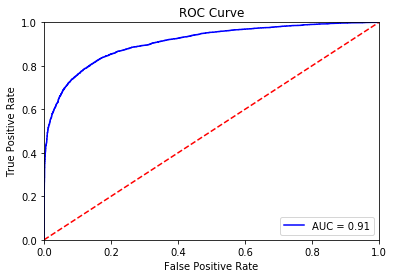

In [73]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(x_val)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()